# Swap-curve bootstrapping examples 
\[The exposition follows -- as much as possible -- the approach shown in Chapters 8 and 9 of the Quantlib Python Cookbook (QPC) by Balaraman and Ballabio.\]

Part 1 will show how to perform a single-curve bootstrap of the USD Libor curve.  I will use data on overnight and certain term Libors, intermediate term FRA instruments, and 3M Libor swaps on the long end. In terms of Bbg symbols, I will be experimenting with these instruments: 'US00ON', 'US0001W', 'US0001M', 'US0003M', 'US0006M', 'US0012M', 'USSWAP1', 'USSWAP2', 'USSWAP3', 'USSWAP4', 'USSWAP5', 'USSWAP6', 'USSWAP7', 'USSWAP8', 'USSWAP9', 'USSWAP10', 'USSWAP11', 'USSWAP12', 'USSWAP15', 'USSWAP20', 'USSWAP25', 'USSWAP30', 'USSWAP40', 'USSWAP50', 'FRA0306', 'FRA0609', 'FRA0912', 'FRA1215', 'FRA1518', 'FRA1821', 'FRA2124'. (I will show what works and what does not based on some experimentation.)

Part 2 will show how to perform a dual-curve bootstrap of the USD Libor swap curve using OIS discounting. The bootstap will be performed by first constructing an OIS discount curve using the Fed Funds rate, and overnight interest swaps at various tenors. I will be using Bbg data on these symbols: 'FEDL01', 'USSO1Z', 'USSO2Z', 'USSO3Z', 'USSOA', 'USSOB', 'USSOC', 'USSOD', 'USSOE', 'USSOF', 'USSOI', 'USSO1', 'USSO2', 'USSO3', 'USSO4', 'USSO5', 'USSO10'. One may note that the longest maturity among these is the 10Y OIS; so the discounting of long-dated Libor cash flows is done using a significant extrapolation. This owes to data limitations stemming from illiquidity of long-dated OIS. 

Part 3 will attempt to remedy the limitation of the OIS discounting curve noted above. Common practice is to use long-dated OIS-Libor basis swaps in conjunction with Libor swaps to construct synthetic OIS rates for the long maturities. I will show how this may be done. In addition to the data described above, I will be using data on some of these Bbg symbols: 'USBG12', 'USBG15', 'USBG20', 'USBG25', 'USBG30', 'USBG40', 'USBG50'. 


The following dictionary contains quotes from Bbg for instruments on 2017-02-21. (Note that Bbg quotes most of these in units of percentage points, so the values shown here are actually Bbg quotes times 100!)

In [1]:
text_date = '2017-02-21'
quotes = {'US00ON' : 0.0068611, 'US0001W' : 0.0071444, 'US0001M' : 0.0077944,
          'US0003M' : 0.0105344,'US0006M' : 0.0136239,'US0012M' : 0.0174539,
          'USSWAP1' : 0.013239,'USSWAP2' : 0.015828,'USSWAP3' : 0.017784,
          'USSWAP4' : 0.019295,'USSWAP5' : 0.02045,'USSWAP6' : 0.021438,
          'USSWAP7' : 0.022258,'USSWAP8' : 0.022968,'USSWAP9' : 0.023563,
          'USSWAP10' : 0.02408,'USSWAP11' : 0.024537,'USSWAP12' : 0.024945,
          'USSWAP15' : 0.025763,'USSWAP20' : 0.026498,'USSWAP25' : 0.026745,
          'USSWAP30' : 0.026818,'USSWAP40' : 0.026704,'USSWAP50' : 0.026465,
          'FRA0306' : 0.012732,'FRA0609' : 0.01378,'FRA0912' : 0.015255,
          'FRA1215' : 0.01652,'FRA1518' : 0.018011,'FRA1821' : 0.01875,
          'FRA2124' : 0.0198,
          'FEDL01' : 0.0066,'USSO1Z' : 0.006445,
          'USSO2Z' : 0.006455,'USSO3Z' : 0.00645,'USSOA' : 0.00675,
          'USSOB' : 0.007,'USSOC' : 0.00724,'USSOD' : 0.007533,
          'USSOE' : 0.00785,'USSOF' : 0.00814,'USSOI' : 0.00889,
          'USSO1' : 0.00967,'USSO2' : 0.01221,'USSO3' : 0.01413,
          'USSO4' : 0.01555,'USSO5' : 0.01672,'USSO10' : 0.02005,
          'USSO12' : 0.0208,'USSO15' : 0.02152,'USSO20' : 0.02215,
          'USSO25' : 0.02233,'USSO30' : 0.02234,'USSO40' : 0.02233,
          'USBG12' : 39.5,'USBG15' : 40.4,'USBG20' : 41.5,
          'USBG25' : 42.4,'USBG30' : 42.75 }

In [2]:
import pandas as pd
import QuantLib as ql
import numpy as np

## Part 1: Single curve bootstrap of USD Libor swap curve


In [3]:
evaluation_date = ql.Date(int(text_date[8:10]), int(text_date[5:7]), int(text_date[0:4]))
ql.Settings.instance().evaluationDate = evaluation_date

### Set up the Libor deposit rate helpers.
There are problems using 6M and 12M libor quotes, so I don't use them. 
First, the pillars induced by US0006 conflict with that induced by FRA0306; US0012 conflicts with FRA0912. This means that these instrument pairs cannot be used together when using the QL ```PiecewiseLogCubicDiscount()``` bootstrap procedure. 
Second, and more fundamentally, the 6M and 12M USD Libors seem to have significantly different risk characteristics than 3M Libor, so that using them together with these other instruments to construct a 3M Libor swap curve (or a discounting curve in a single curve bootstrap) screws up your curve at the short end. (This should not be surprising, as they are now considered risky assets, and these have longer terms to repayment!) This can be seen by using these instruments rather than FRA0306 and FRA0912 in the bootstrap. (FRA0609 can be left in the procedure, as it does not induce a pillar conflict; and leaving it in exacerbates the pathology, as it induces a pillar midway between the 6M and the 12M deposits!)

In [4]:
# I take attributes for overnight and term Libor deposits from QL defaults for 3M Libor:
# (C++ users might be able to avoid this by using DailyTenorUSDLibor(); this has been implemented in Python QL SWIG, yet.) 
libor3 = ql.USDLibor(ql.Period(3,ql.Months))
#libor_deposit_day_count = libor3.dayCounter()
#libor_deposit_settlement_days = libor3.fixingDays()
#libor_deposit_adjustment = libor3.businessDayConvention() 
#libor_deposit_calendar = libor3.fixingCalendar() 
#libor_deposit_end_of_month = libor3.endOfMonth() 

In [5]:
# Start with ON libor rate, US00ON; assume 0 fixing days
rate_helpers1 = [ql.DepositRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(quotes['US00ON'])),
                ql.Period(1, ql.Days), 
                0, 
                libor3.fixingCalendar(),
                libor3.businessDayConvention(),
                libor3.endOfMonth(), 
                libor3.dayCounter() ) ]

In [6]:
# Next, add the libor term rates up to 3M
rate_helpers1 += [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                        maturity, 
                        libor3.fixingDays(), 
                        libor3.fixingCalendar(),
                        libor3.businessDayConvention(),
                        libor3.endOfMonth(), 
                        libor3.dayCounter() )
                   for rate, maturity in [
                       (quotes['US0001W'], ql.Period(1, ql.Weeks)),
                       (quotes['US0001M'], ql.Period(1, ql.Months)),
                       (quotes['US0003M'], ql.Period(3, ql.Months))] ]

### Set up the FRA rate helpers.

We cannot use both FRA0912 and USSWAP1, as these induce a pillar conflict in the ```ql.PiecewiseLogCubicDiscount()``` bootstrap procedure. 
Similarly, 'FRA2124' induces a confict with 'USSWAP2'. Thus, we must make some choices with respect to which instruments to utilize in our bootstrap. Unlike the 6M and 12M deposits, however, these choice don't seem to matter much. This is evidence that these instruments have consistent risk properties. 

Note: the version of ```FraRateHelper()``` that takes ```ql.USDLibor()``` as an input (used here) is a great convenience compared with the one requiring inputs ```settlement_days, Calendar, BusinessDayConvention, end_of_month_bool```, and ```DayCounter```
that I have used previously.

In [7]:
# trying the implementation of FRARateHelper() that takes ql.libor() as an input...
rate_helpers1 += [ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                             months_to_start, ql.USDLibor(ql.Period(3,ql.Months))) 
            for rate, months_to_start in [
                (quotes['FRA0306'], 3), 
                (quotes['FRA0609'], 6),
                (quotes['FRA0912'], 9),
                (quotes['FRA1215'], 12),
                (quotes['FRA1518'], 15),
                (quotes['FRA1821'], 18)] ]

### Set up the swap rate helpers.
In the same way that the pillars induced by FRA2124 and USSWAP2 conflict, those of FRA0912 and USSWAP1 conflict. Therefore, I do not use the 1Y swap. 


In [8]:
swap_calendar = ql.UnitedStates()
#swap_settlement_days = 2
swap_fixed_leg_frequency = ql.Semiannual
swap_fixed_leg_day_count = ql.Thirty360() 
swap_fixed_leg_adjustment = ql.ModifiedFollowing # aka "business convention", affects how day counts are determined from the calendar
# most of the floating leg terms are embedded in spec'n of the index, below...
swap_float_index = ql.USDLibor(ql.Period(3,ql.Months))


In [9]:
rate_helpers1 += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                              ql.Period(tenor, ql.Years), swap_calendar,
                              swap_fixed_leg_frequency, swap_fixed_leg_adjustment,
                              swap_fixed_leg_day_count, swap_float_index )
            for rate, tenor in [(quotes['USSWAP2'], 2),
                                (quotes['USSWAP3'], 3),
                                (quotes['USSWAP4'], 4),
                                (quotes['USSWAP5'], 5),
                                (quotes['USSWAP6'], 6),
                                (quotes['USSWAP7'], 7),
                                (quotes['USSWAP8'], 8),
                                (quotes['USSWAP9'], 9),
                                (quotes['USSWAP10'], 10),
                                (quotes['USSWAP11'], 11),
                                (quotes['USSWAP12'], 12),
                                (quotes['USSWAP15'], 15),
                                (quotes['USSWAP20'], 20),
                                (quotes['USSWAP25'], 25),
                                (quotes['USSWAP30'], 30),
                                (quotes['USSWAP40'], 40),
                                (quotes['USSWAP50'], 50)] ]


### Bootstrap
Taking at face value the claim on page 63 of QPC that "\[t\]he day counter chosen is not of much consequence, as it is only used internally to convert dates into times"...

In [10]:
swap_curve1 = ql.PiecewiseLogCubicDiscount(
                0, ql.UnitedStates(), rate_helpers1, ql.Actual365Fixed())
swap_curve1.enableExtrapolation()

### Examine the curves

In [11]:
%matplotlib inline
#import utils
#from matplotlib.ticker import FuncFormatter
#import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [12]:
def plot_swap_curve(swap_curve, start_ql_date, end_ql_date, 
                        what_to_plot = 'zeros'):
    '''
    what to plot can be a list containing one or more elements of 
    ['zeros', 'forwards', 'discounts']; or it can be just one of  
    the elements of this list. (But note that plotting 'discounts' 
    together with 'zeros' or 'forwards' doesn't come out too well!)
    '''
    default_plot_size = (10,5)
    
    dates = [start_ql_date + ql.Period(i,ql.Days) for i in range(0, end_ql_date-start_ql_date+1)]
    dates_ = [ dt.date(d.year(), d.month(), d.dayOfMonth()) for d in dates ]
    
    f = plt.figure(figsize = default_plot_size)
    ax = f.add_axes([0,0,1,1])
    ax.xaxis.grid(True, 'major', color=(0.9, 0.9, 0.9))
    ax.yaxis.grid(True, 'major', color=(0.9, 0.9, 0.9))
    
    if 'zeros' in what_to_plot:
        y = [swap_curve.zeroRate(d, ql.Actual360(), 
                                      ql.Continuous).rate() for d in dates]
        ax.plot_date(dates_, y, '-')
    if 'forwards' in what_to_plot:
        y = [swap_curve.forwardRate(
            d, calendar.advance(d, 1, ql.Days), ql.Actual360(), ql.Continuous).rate() 
             for d in dates]
        ax.plot_date(dates_, y, '-')
    if 'discounts' in what_to_plot:
        y = [swap_curve.discount(d) 
             for d in dates]
        ax.plot_date(dates_, y, '-')
    
    ax.axhline(0.0, linewidth=1, color=(0.5,0.5,0.5))
    
    plt.show()
#


In [13]:
ql_date = ql.Date(int(text_date[8:10]), int(text_date[5:7]), 
                          int(text_date[0:4]) )
ql.Settings.instance().evaluationDate = ql_date
spot = ql_date

calendar = ql.UnitedStates()

In [14]:
start_ql_date = ql_date
end_ql_date = start_ql_date + ql.Period(50, ql.Years)

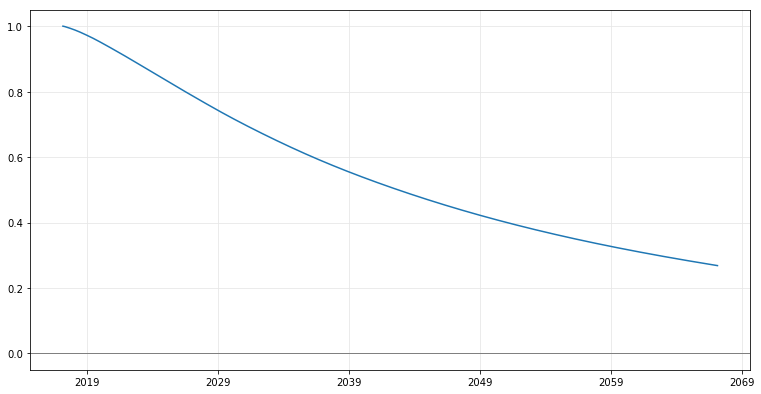

In [15]:
plot_swap_curve(swap_curve1, start_ql_date, end_ql_date, 
                        what_to_plot = ['discounts'])

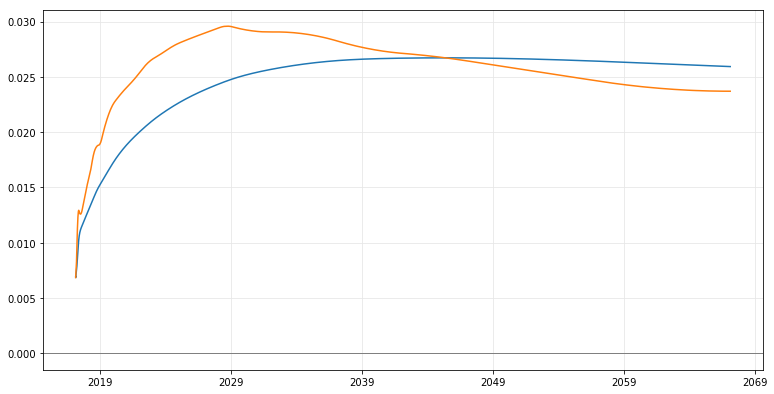

In [16]:
plot_swap_curve(swap_curve1, start_ql_date, end_ql_date, 
                        what_to_plot = ['zeros','forwards'])

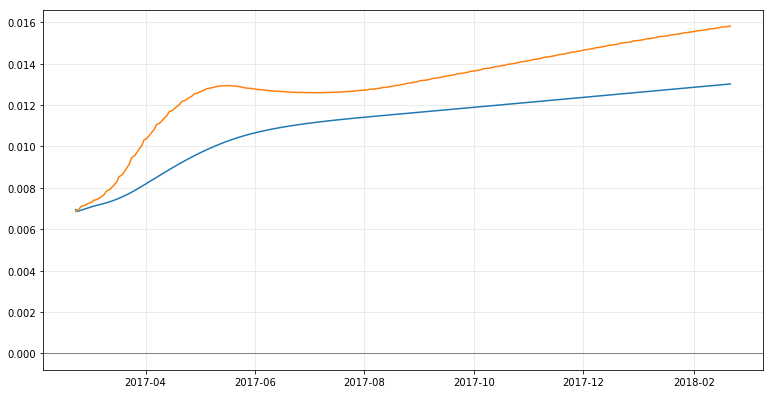

In [17]:
# a close-up in the short end...
end_ql_date2 = start_ql_date + ql.Period(1, ql.Years)
plot_swap_curve(swap_curve1, start_ql_date, end_ql_date2, 
                        what_to_plot = ['zeros','forwards'])

### Let's show that a par swap has NPV of zero at initiation.
I follow Ch.19 of QPC to define a fixed-for-floating IRS and price it using the constructed curve as 3M Libor forecaster. The difference is that I will put the fixed rate equal to the par rate.
The par fixed rate for a 10Y fixed for 3M Libor IRS was 2.408% on 2017-02-21. 

(Thanks to QuantLib-users newsgroup participants for help tracking down a bug in my specification of standard swap terms!)

In [18]:
swap_curve1_handle = ql.YieldTermStructureHandle(swap_curve1)
swap_float_index1 = ql.USDLibor(ql.Period(3,ql.Months), swap_curve1_handle)

settle_date1 = calendar.advance(evaluation_date, 2, ql.Days)
maturity_date1 = calendar.advance(settle_date1, 10, ql.Years) 
fixed_leg_tenor = ql.Period(6, ql.Months)
business_convention = ql.ModifiedFollowing
termination_business_convention = ql.ModifiedFollowing
fixed_schedule1 = ql.Schedule(settle_date1, maturity_date1, 
                            fixed_leg_tenor, calendar,
                            business_convention, termination_business_convention, 
                            ql.DateGeneration.Backward, False)
float_leg_tenor = ql.Period(3, ql.Months)
float_schedule1 = ql.Schedule(settle_date1, maturity_date1, 
                            float_leg_tenor, calendar,
                            business_convention, termination_business_convention, 
                            ql.DateGeneration.Backward, False)
notional = 10000000
fixed_rate1 = quotes['USSWAP10'] 
fixed_leg_daycount = ql.Thirty360()
float_spread1 = 0.000 
float_leg_daycount = ql.Actual360()

irs1 = ql.VanillaSwap(ql.VanillaSwap.Payer, notional, fixed_schedule1,
                    fixed_rate1, fixed_leg_daycount, float_schedule1,
                    swap_float_index1, float_spread1, 
                     float_leg_daycount)

pricing_engine1 = ql.DiscountingSwapEngine(swap_curve1_handle)
irs1.setPricingEngine(pricing_engine1)

In [19]:
print("%-20s: %20.3f" % ("Net Present Value", irs1.NPV()))
print("%-20s: %20.3f" % ("Fair Spread", irs1.fairSpread()))
print("%-20s: %20.3f" % ("Fair Rate", irs1.fairRate()))
print("%-20s: %20.3f" % ("Fixed Leg BPS", irs1.fixedLegBPS()))
print("%-20s: %20.3f" % ("Floating Leg BPS", irs1.floatingLegBPS()))

Net Present Value   :                0.000
Fair Spread         :               -0.000
Fair Rate           :                0.024
Fixed Leg BPS       :            -8945.141
Floating Leg BPS    :             9101.401


### N.B. Continuous compounding makes a big difference when computing zero rates!
QPC constructs forward curves in Chs.8 and 9 by specifying simple compounding (via ```ql.Simple()```). This is essentially irrelevant when computing instantaneous (actually, 1-day) forward rates as we are doing here. BUT (and this set me back some hours when I was comparing to graphs that Bbg spits out!) it makes a big difference when constructing zero rates; this is especially so on the long end. To wit: 

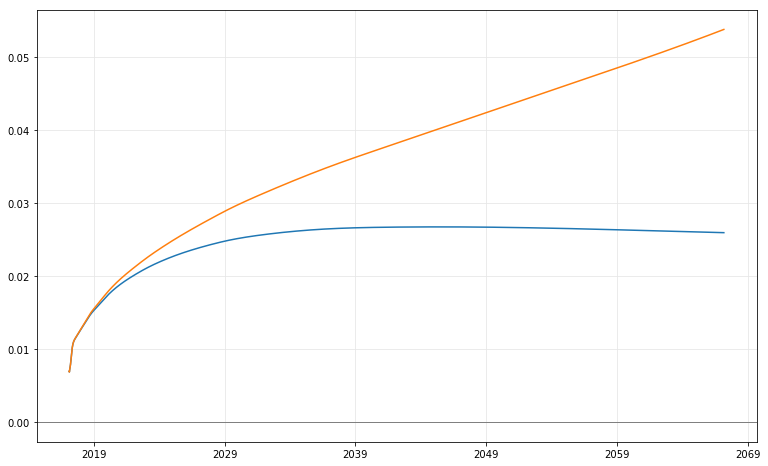

In [20]:
dates = [start_ql_date + ql.Period(i,ql.Days) for i in range(0, end_ql_date-start_ql_date+1)]
dates_ = [ dt.date(d.year(), d.month(), d.dayOfMonth()) for d in dates ]

default_plot_size = (10,6)
f = plt.figure(figsize = default_plot_size)
ax = f.add_axes([0,0,1,1])
ax.xaxis.grid(True, 'major', color=(0.9, 0.9, 0.9))
ax.yaxis.grid(True, 'major', color=(0.9, 0.9, 0.9))

zero_continuous = [swap_curve1.zeroRate(d, ql.Actual360(), ql.Continuous).rate()
                  for d in dates]
ax.plot_date(dates_, zero_continuous, '-')

zero_simple = [swap_curve1.zeroRate(d, ql.Actual360(), ql.Simple).rate() 
         for d in dates]
ax.plot_date(dates_, zero_simple, '-')
ax.axhline(0.0, linewidth=1, color=(0.5,0.5,0.5))

### Just for the record
Let's see what happens when we try to use the 6M and 12M Libors.

In [21]:
rate_helpers1_1 = [ql.DepositRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(quotes['US00ON'])),
                ql.Period(1, ql.Days), 
                0, 
                libor3.fixingCalendar(),
                libor3.businessDayConvention(),
                libor3.endOfMonth(), 
                libor3.dayCounter()  ) ]

rate_helpers1_1 += [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                                maturity, 
                                libor3.fixingDays(), 
                                libor3.fixingCalendar(),
                                libor3.businessDayConvention(),
                                libor3.endOfMonth(), 
                                libor3.dayCounter()  )
           for rate, maturity in [
               (quotes['US0001W'], ql.Period(1, ql.Weeks)),
               (quotes['US0001M'], ql.Period(1, ql.Months)),
               (quotes['US0003M'], ql.Period(3, ql.Months)),
               (quotes['US0006M'], ql.Period(6, ql.Months)), # CHANGED HERE!
               (quotes['US0012M'], ql.Period(12, ql.Months))] ] # CHANGED HERE!

rate_helpers1_1 += [ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                             months_to_start, ql.USDLibor(ql.Period(3,ql.Months))) 
            for rate, months_to_start in [
                #(quotes['FRA0306'], 3), CHANGED HERE!
                (quotes['FRA0609'], 6),
                #(quotes['FRA0912'], 9), CHANGED HERE!
                (quotes['FRA1215'], 12),
                (quotes['FRA1518'], 15),
                (quotes['FRA1821'], 18)] ]

rate_helpers1_1 += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                              ql.Period(tenor, ql.Years), swap_calendar,
                              swap_fixed_leg_frequency, swap_fixed_leg_adjustment,
                              swap_fixed_leg_day_count, swap_float_index )
            for rate, tenor in [(quotes['USSWAP2'], 2),
                                (quotes['USSWAP3'], 3),
                                (quotes['USSWAP4'], 4),
                                (quotes['USSWAP5'], 5),
                                (quotes['USSWAP6'], 6),
                                (quotes['USSWAP7'], 7),
                                (quotes['USSWAP8'], 8),
                                (quotes['USSWAP9'], 9),
                                (quotes['USSWAP10'], 10),
                                (quotes['USSWAP11'], 11),
                                (quotes['USSWAP12'], 12),
                                (quotes['USSWAP15'], 15),
                                (quotes['USSWAP20'], 20),
                                (quotes['USSWAP25'], 25),
                                (quotes['USSWAP30'], 30),
                                (quotes['USSWAP40'], 40),
                                (quotes['USSWAP50'], 50)] ]

swap_curve1_1 = ql.PiecewiseLogCubicDiscount(
                0, ql.UnitedStates(), rate_helpers1_1, ql.Actual365Fixed())
swap_curve1_1.enableExtrapolation()

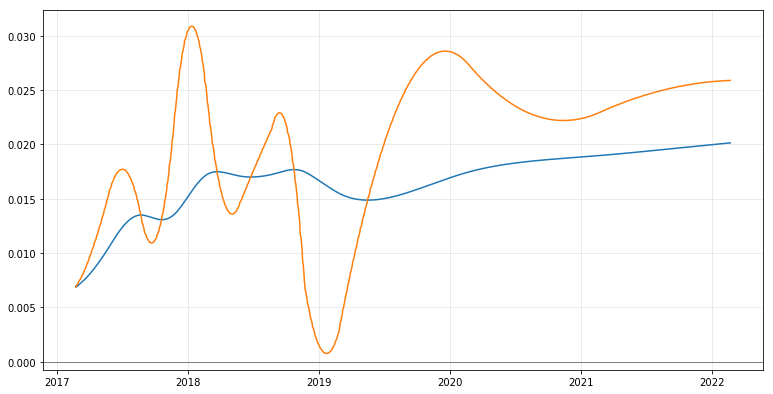

In [22]:
plot_swap_curve(swap_curve1_1, start_ql_date, (start_ql_date + ql.Period(5, ql.Years)), 
                        what_to_plot = ['zeros','forwards'])

The zero curve is slightly smoother if we drop the intermediate FRA0609, but these curve still don't look like a good option.

In [23]:
rate_helpers1_2 = [ql.DepositRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(quotes['US00ON'])),
                ql.Period(1, ql.Days), 
                0, 
                libor3.fixingCalendar(),
                libor3.businessDayConvention(),
                libor3.endOfMonth(), 
                libor3.dayCounter() ) ]

rate_helpers1_2 += [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                                maturity, 
                                libor3.fixingDays(), 
                                libor3.fixingCalendar(),
                                libor3.businessDayConvention(),
                                libor3.endOfMonth(), 
                                libor3.dayCounter() )
           for rate, maturity in [
               (quotes['US0001W'], ql.Period(1, ql.Weeks)),
               (quotes['US0001M'], ql.Period(1, ql.Months)),
               (quotes['US0003M'], ql.Period(3, ql.Months)),
               (quotes['US0006M'], ql.Period(6, ql.Months)), # CHANGED HERE!
               (quotes['US0012M'], ql.Period(12, ql.Months))] ] # CHANGED HERE!

rate_helpers1_2 += [ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                             months_to_start, ql.USDLibor(ql.Period(3,ql.Months))) 
            for rate, months_to_start in [
                #(quotes['FRA0306'], 3),  CHANGED HERE!
                #(quotes['FRA0609'], 6),*** CHANGED HERE! ***
                #(quotes['FRA0912'], 9),   CHANGED HERE!
                (quotes['FRA1215'], 12),
                (quotes['FRA1518'], 15),
                (quotes['FRA1821'], 18)] ]

rate_helpers1_2 += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                              ql.Period(tenor, ql.Years), swap_calendar,
                              swap_fixed_leg_frequency, swap_fixed_leg_adjustment,
                              swap_fixed_leg_day_count, swap_float_index )
            for rate, tenor in [(quotes['USSWAP2'], 2),
                                (quotes['USSWAP3'], 3),
                                (quotes['USSWAP4'], 4),
                                (quotes['USSWAP5'], 5),
                                (quotes['USSWAP6'], 6),
                                (quotes['USSWAP7'], 7),
                                (quotes['USSWAP8'], 8),
                                (quotes['USSWAP9'], 9),
                                (quotes['USSWAP10'], 10),
                                (quotes['USSWAP11'], 11),
                                (quotes['USSWAP12'], 12),
                                (quotes['USSWAP15'], 15),
                                (quotes['USSWAP20'], 20),
                                (quotes['USSWAP25'], 25),
                                (quotes['USSWAP30'], 30),
                                (quotes['USSWAP40'], 40),
                                (quotes['USSWAP50'], 50)] ]

swap_curve1_2 = ql.PiecewiseLogCubicDiscount(
                0, ql.UnitedStates(), rate_helpers1_2, ql.Actual365Fixed())
swap_curve1_2.enableExtrapolation()

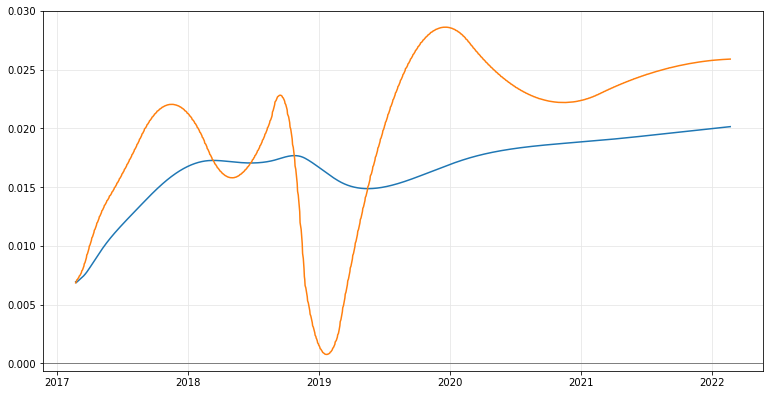

In [24]:
plot_swap_curve(swap_curve1_2, start_ql_date, (start_ql_date + ql.Period(5, ql.Years)), 
                        what_to_plot = ['zeros','forwards'])

## Part 2: USD Libor swap curve with OIS discounting
We begin this part by constructing the OIS curve that will serve as the discount curve for our Libor swap curve. 

0 settlement days for ff funds assumed.

Per Bbg, OIS (even short tenors) has 2 day settlement. This is consistent with OpenGamma doc. 

In [25]:
# Indexes...
ff = ql.FedFunds()

# OIS...
ois_settlement_days = 2 #

# ARE THESE USED!?!

#ois_fixed_leg_frequency = ql.Annual
#ois_fixed_leg_day_count = ql.Actual360() 
#ois_fixed_leg_adjustment = ql.ModifiedFollowing 
ois_float_index = ff 
# according to OpenGamma doc, float pmts are typ made at the same freq (annual) as 
# the floating leg. Also, there is a payment lag of 2 days on OIS:
ois_paymentLag = 2

In [26]:
# The FF index is implemented as an overnight deposit rate with zero days to 
# settle...
ff_rate_helpers2 = [ql.DepositRateHelper(
                    ql.QuoteHandle(ql.SimpleQuote(quotes['FEDL01'])),
                    ql.Period(1, ql.Days), 
                    ff.fixingDays(), 
                    ff.fixingCalendar(),
                    ff.businessDayConvention(),
                    ff.endOfMonth() , 
                    ff.dayCounter() ) ]

ff_rate_helpers2 += [ql.OISRateHelper(
                    ois_settlement_days,
                    tenor,
                    ql.QuoteHandle(ql.SimpleQuote(rate)),
                    ois_float_index,
                    ql.YieldTermStructureHandle(),
                    False,
                    ois_paymentLag) 
                  for rate, tenor in [
                        (quotes['USSO1Z'], ql.Period(1, ql.Weeks)),
                        (quotes['USSO2Z'], ql.Period(2, ql.Weeks)),
                        (quotes['USSO3Z'], ql.Period(3, ql.Weeks)),
                        (quotes['USSOA'], ql.Period(1, ql.Months)),
                        (quotes['USSOB'], ql.Period(2, ql.Months)),
                        (quotes['USSOC'], ql.Period(3, ql.Months)),
                        (quotes['USSOD'], ql.Period(4, ql.Months)),
                        (quotes['USSOE'], ql.Period(5, ql.Months)),
                        (quotes['USSOF'], ql.Period(6, ql.Months)),
                        (quotes['USSOI'], ql.Period(9, ql.Months)),
                        (quotes['USSO1'], ql.Period(1, ql.Years)),
                        (quotes['USSO2'], ql.Period(2, ql.Years)),
                        (quotes['USSO3'], ql.Period(3, ql.Years)),
                        (quotes['USSO4'], ql.Period(4, ql.Years)),
                        (quotes['USSO5'], ql.Period(5, ql.Years)),
                        (quotes['USSO10'], ql.Period(10, ql.Years)),
                        (quotes['USSO12'], ql.Period(12, ql.Years)),
                        (quotes['USSO15'], ql.Period(15, ql.Years)),
                        (quotes['USSO20'], ql.Period(20, ql.Years)),
                        (quotes['USSO25'], ql.Period(25, ql.Years)),
                        (quotes['USSO30'], ql.Period(30, ql.Years)),
                        (quotes['USSO40'], ql.Period(40, ql.Years)) ] ]


In [27]:
ois_curve2 = ql.PiecewiseLogCubicDiscount(
                0, ql.UnitedStates(), ff_rate_helpers2, ql.Actual365Fixed())
ois_curve2.enableExtrapolation()

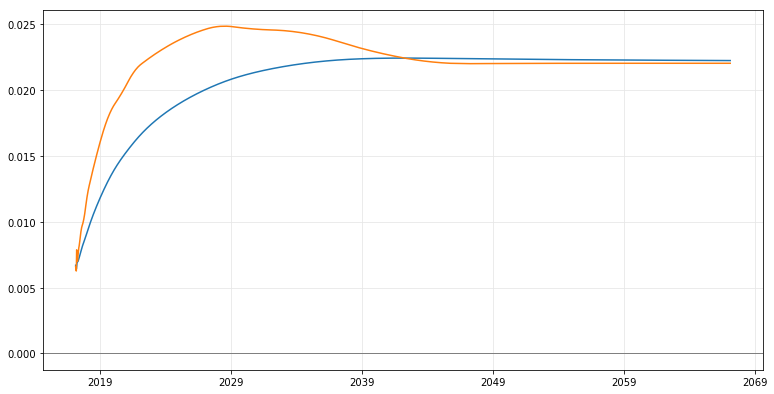

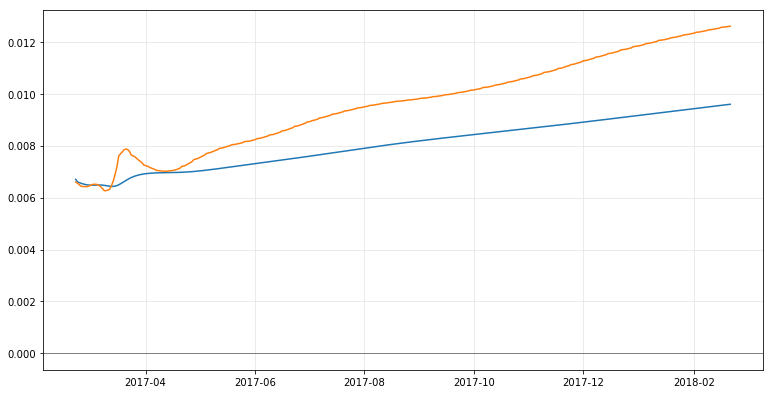

In [28]:
plot_swap_curve(ois_curve2, start_ql_date, end_ql_date, 
                        what_to_plot = ['zeros','forwards'])

# close up on the forward curve wobble...
plot_swap_curve(ois_curve2, start_ql_date, end_ql_date2, 
                        what_to_plot = ['zeros','forwards'])

I constructed the following table to make comparisons with bootstrap from Bbg's ICVS page. The resulting zeros are within a few basis points, tentatively a success IMO. (Continuous compounding the zeros is obvious important!)

In [29]:
dates = ([start_ql_date + ql.Period(i,ql.Years) for i in range(0, 5)] +
         [start_ql_date + ql.Period(10,ql.Years) + ql.Period(10*i,ql.Years) for i in range(0, 5)])
    
dates_ = [ dt.date(d.year(), d.month(), d.dayOfMonth()) for d in dates ]

zeros = [ois_curve2.zeroRate(d, ql.Actual360(), 
                                  ql.Continuous).rate() for d in dates]
discounts = [ois_curve2.discount(d) for d in dates]

pd.DataFrame([ (date, zero, discount) for date, zero, discount in zip(dates_, zeros, discounts)],
            columns = ["date", "zero", "discount"])

,date,zero,discount
0,2017-02-21,0.006703,1.000000
1,2018-02-21,0.009590,0.990324
2,2019-02-21,0.012111,0.975741
3,2020-02-21,0.014042,0.958188
4,2021-02-21,0.015476,0.939127
5,2027-02-21,0.020084,0.815675
6,2037-02-21,0.022289,0.636171
7,2047-02-21,0.022391,0.505859
8,2057-02-21,0.022302,0.404510
9,2067-02-21,0.022250,0.323453


For kicks, I verify that the at-par 20Y OIS has zero NPV when priced against this curve. This exercise has the value of ensuring that we know what terms have been assumed for OIS in the bootstrapping procedure, and making sure those agree with the real-world (i.e., the Bbg data). 

In [30]:
discount_curve_handle2 = ql.RelinkableYieldTermStructureHandle()
discount_curve_handle2.linkTo(ois_curve2)

In [31]:
#ois_curve2_handle = ql.YieldTermStructureHandle(ois_curve2)
#ois_index = ql.FedFunds(ois_curve1_handle)
ff_index = ql.FedFunds(discount_curve_handle2) # this handle does not need to be "relinkable"; not sure what that does for us.

# this is a 20Y swap (because i have data on the 20Y basis swap also)
ois_settle_date = calendar.advance(evaluation_date, 2, ql.Days)
ois_maturity_date = calendar.advance(settle_date1, 20, ql.Years) 
ois_fixed_leg_tenor = ql.Period(12, ql.Months) 
ois_fixed_business_convention = ql.ModifiedFollowing
ois_fixed_termination_business_convention = ql.ModifiedFollowing
ois_fixed_schedule = ql.Schedule(ois_settle_date, ois_maturity_date, 
                            ois_fixed_leg_tenor, calendar,
                            ois_fixed_business_convention, 
                            ois_fixed_termination_business_convention, 
                            ql.DateGeneration.Backward, False)

ois_float_leg_tenor = ql.Period(12, ql.Months) 

# I believe the float schedule is constrained to be identical to the fixed one, per convention.

notional = 10000000
ois_fixed_rate1 = quotes['USSO20'] # quotes['USSO20'] = 0.02215 ... 0.02214991 => 0.701 NPV
ois_fixed_leg_daycount = ql.Actual360()
#float_spread1 = 0.000 
#float_leg_daycount = ql.Actual360()

ois_paymentCalendar = calendar
ois_spread = 0
ois_paymentLag = 2

ois20 = ql.OvernightIndexedSwap(ql.OvernightIndexedSwap.Payer, 
                               notional, 
                               ois_fixed_schedule,
                               ois_fixed_rate1, 
                               ois_fixed_leg_daycount, 
                               ff_index, #ois_index,
                               ois_spread,
                               ois_paymentLag,
                               ql.ModifiedFollowing, # ?
                               ois_paymentCalendar,
                               False )

ois_pricing_engine = ql.DiscountingSwapEngine(discount_curve_handle2)
ois20.setPricingEngine(ois_pricing_engine)

In [32]:
print("%-20s: %20.3f" % ("Net Present Value", ois20.NPV()))
print("%-20s: %20.3f" % ("Fair Spread", ois20.fairSpread()))
print("%-20s: %20.3f" % ("Fair Rate", ois20.fairRate()))
print("%-20s: %20.3f" % ("Fixed Leg BPS", ois20.fixedLegBPS()))
#print("%-20s: %20.3f" % ("Floating Leg BPS", ois20.floatingLegBPS()))

Net Present Value   :               -0.000
Fair Spread         :                0.000
Fair Rate           :                0.022
Fixed Leg BPS       :           -16425.133


To build the new swap curve, we need to rebuild the rate_helpers to give the discount curve to the swap helper...


In [33]:
#now build swap_rate_helpers2
#discount_curve_handle2 = ql.RelinkableYieldTermStructureHandle()
#discount_curve_handle2.linkTo(ois_curve2)

In [34]:
swap_rate_helpers2 = [ql.DepositRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(quotes['US00ON'])),
                ql.Period(1, ql.Days), 
                0, 
                libor3.fixingCalendar(),
                libor3.businessDayConvention(),
                libor3.endOfMonth(), 
                libor3.dayCounter() ) ]

swap_rate_helpers2 += [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                                maturity, 
                                libor3.fixingDays(), 
                                libor3.fixingCalendar(),
                                libor3.businessDayConvention(),
                                libor3.endOfMonth(), 
                                libor3.dayCounter() )
           for rate, maturity in [
               (quotes['US0001W'], ql.Period(1, ql.Weeks)),
               (quotes['US0001M'], ql.Period(1, ql.Months)),
               (quotes['US0003M'], ql.Period(3, ql.Months))] ] 

swap_rate_helpers2 += [ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                             months_to_start, ql.USDLibor(ql.Period(3,ql.Months))) 
            for rate, months_to_start in [
                (quotes['FRA0306'], 3), 
                (quotes['FRA0609'], 6),
                (quotes['FRA0912'], 9),
                (quotes['FRA1215'], 12),
                (quotes['FRA1518'], 15),
                (quotes['FRA1821'], 18)] ]

swap_rate_helpers2 += [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)),
                            ql.Period(tenor, ql.Years), swap_calendar,
                            swap_fixed_leg_frequency, swap_fixed_leg_adjustment,
                            swap_fixed_leg_day_count, swap_float_index,
                            ql.QuoteHandle(),
                            ql.Period(0,ql.Days),
                            discount_curve_handle2 )
            for rate, tenor in [(quotes['USSWAP2'], 2),
                                (quotes['USSWAP3'], 3),
                                (quotes['USSWAP4'], 4),
                                (quotes['USSWAP5'], 5),
                                (quotes['USSWAP6'], 6),
                                (quotes['USSWAP7'], 7),
                                (quotes['USSWAP8'], 8),
                                (quotes['USSWAP9'], 9),
                                (quotes['USSWAP10'], 10),
                                (quotes['USSWAP11'], 11),
                                (quotes['USSWAP12'], 12),
                                (quotes['USSWAP15'], 15),
                                (quotes['USSWAP20'], 20),
                                (quotes['USSWAP25'], 25),
                                (quotes['USSWAP30'], 30),
                                (quotes['USSWAP40'], 40),
                                (quotes['USSWAP50'], 50)] ]

swap_curve2 = ql.PiecewiseLogCubicDiscount(
                0, ql.UnitedStates(), swap_rate_helpers2, ql.Actual365Fixed())
swap_curve2.enableExtrapolation()

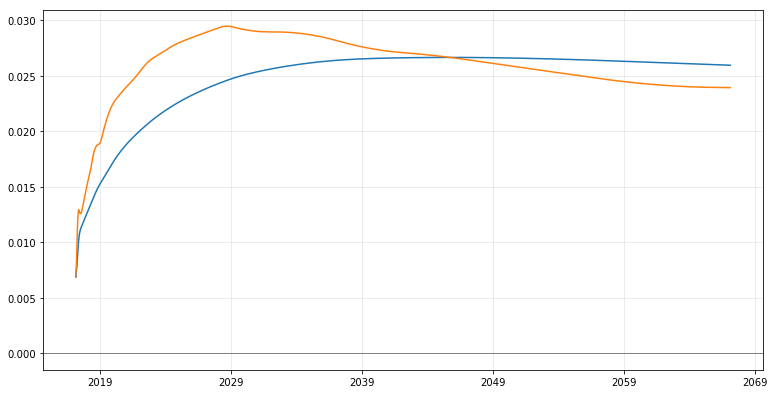

In [35]:
plot_swap_curve(swap_curve2, start_ql_date, end_ql_date, 
                        what_to_plot = ['zeros', 'forwards'])


### Verify that our 10Y par swap has zero NPV according to the new pricing curve

In [36]:
swap_curve2_handle = ql.YieldTermStructureHandle(swap_curve2)
swap_float_index2 = ql.USDLibor(ql.Period(3,ql.Months), swap_curve2_handle)

irs2 = ql.VanillaSwap(ql.VanillaSwap.Payer, notional, fixed_schedule1,
                    fixed_rate1, fixed_leg_daycount, float_schedule1,
                    swap_float_index2, float_spread1, 
                     float_leg_daycount)

#pricing_engine2 = ql.DiscountingSwapEngine(discount_curve_handle2)
#irs2.setPricingEngine(pricing_engine2)
irs2.setPricingEngine(ois_pricing_engine)

In [37]:
print("%-20s: %20.3f" % ("Net Present Value", irs2.NPV()))
print("%-20s: %20.3f" % ("Fair Spread", irs2.fairSpread()))
print("%-20s: %20.3f" % ("Fair Rate", irs2.fairRate()))
print("%-20s: %20.3f" % ("Fixed Leg BPS", irs2.fixedLegBPS()))
print("%-20s: %20.3f" % ("Floating Leg BPS", irs2.floatingLegBPS()))

Net Present Value   :                0.000
Fair Spread         :               -0.000
Fair Rate           :                0.024
Fixed Leg BPS       :            -9113.364
Floating Leg BPS    :             9268.195


### Let's compare the zero curves calculated under the different bootstrapping methods.


In [38]:
default_plot_size = (10,5)
dates = [start_ql_date + ql.Period(i,ql.Days) for i in range(0, end_ql_date-start_ql_date+1)]
dates_ = [ dt.date(d.year(), d.month(), d.dayOfMonth()) for d in dates ]
zeros1 = [swap_curve1.zeroRate(d, ql.Actual360(), 
                                  ql.Continuous).rate() for d in dates]
zeros2 = [swap_curve2.zeroRate(d, ql.Actual360(), 
                                  ql.Continuous).rate() for d in dates]
discount1 = [swap_curve1.discount(d) for d in dates]
discount2 = [swap_curve2.discount(d) for d in dates]

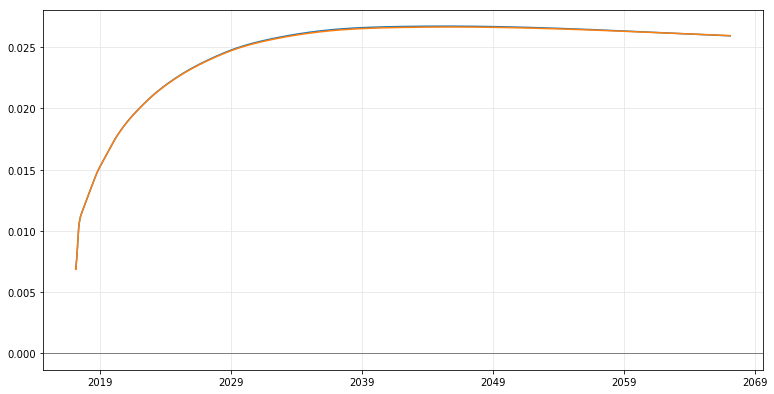

In [39]:
f = plt.figure(figsize = default_plot_size)
ax = f.add_axes([0,0,1,1])
ax.xaxis.grid(True, 'major', color=(0.9, 0.9, 0.9))
ax.yaxis.grid(True, 'major', color=(0.9, 0.9, 0.9))
ax.plot_date(dates_, zeros1, '-')
ax.plot_date(dates_, zeros2, '-')
ax.axhline(0.0, linewidth=1, color=(0.5,0.5,0.5))
plt.show()

The curves look really similar. I guess this shouldn't be surprising since each is an interpolator of market rates! Let's see how similar they are, in fact.

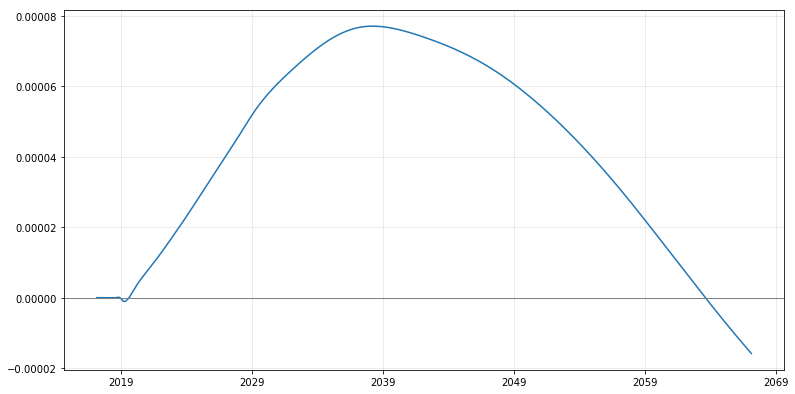

In [40]:
dd = [x-y for x,y in zip(zeros1,zeros2)]
f = plt.figure(figsize = default_plot_size)
ax = f.add_axes([0,0,1,1])
ax.xaxis.grid(True, 'major', color=(0.9, 0.9, 0.9))
ax.yaxis.grid(True, 'major', color=(0.9, 0.9, 0.9))
ax.plot_date(dates_, dd, '-')
ax.axhline(0.0, linewidth=1, color=(0.5,0.5,0.5))
plt.show()

The difference is very small -- less than 1bp at any maturity -- and non-existent at the very short end where deposits and FRAs tell us the market rates exactly.

Interestingly, even though the differences between the forecasting curves "appears" very similar, they are not interchangeable. For example, if we try (in error) to use the forecasting curve derived according to the single-curve methodology with the OIS discounting curve, our par 10Y swap is mispriced:

In [41]:
irs_wrong_forecast = ql.VanillaSwap(ql.VanillaSwap.Payer, notional, fixed_schedule1,
                    fixed_rate1, fixed_leg_daycount, float_schedule1,
                    swap_float_index1, float_spread1, 
                     float_leg_daycount)
irs_wrong_forecast.setPricingEngine(ois_pricing_engine)
print("%-20s: %20.3f" % ("WRONG Net Present Value", irs_wrong_forecast.NPV()))

WRONG Net Present Value:             3646.263


It will be interesting to see how a swap (not at par) would be priced differently under the single versus the dual-curve methodologies.

### Compare prices of swaps priced under two schemes.
(C.f., Ch.19 of QPC.)

I have already shown that the price of a par swap is zero under either approach (by definition and accurate calculation). I will price a swap initiated (at par) one year prior to the evaluation date, and see how the price differs.

On the way, I will need to show how to price a swap at a date after it's initiation date. This is non-trivial (to me), and requires performing some QL manipulations that are not well documented (with no offense to the hard-working administrators of this wonderful tool). 

Here we construct a fixed-for-float swap initiated on 2016-02-29. The par fixed rate for 10Y fixed against 3M Libor was 1.575% (Bbg USSWAP10) on 2016-02-29. (Recall that it was 2.408% on our evaluation_date, 2017-02-21.) Let build that swap and compare it's price on 2017-02-21 according to the two pricing methodologies we have reviewed.


Pricing on 2017-02-21 the swap initiated on 2016-02-29 with standard "in-advance" rate-setting means that we need to know the fixing for 3M Libor for 2017-02-17. The 3M Libor rate on that date was 1.05233%; here are two ways we include that data point in our forecaster:

N.B., as we will see below when use use another instance of ```ql.USDLibor(ql.Period(3, ql.Months)```, "stored fixings are shared between all instances of the same index... They go into a global map whose lookup key is the return value of the ```index.name()``` method" (per L. Ballabio via quantlib-users group). In particular, when we ```addFixing()``` to ```swap_float_index1``` in the next frame, the same fixing will be set for ```swap_float_index2```.


In [42]:
if True:
    swap_float_index1.addFixing(ql.Date(17,2,2017), 0.0105233)
else:
    ''' 
    Alternatively, we can use the following method to specify a time series of fixings. 
    (This may be more convenient to construct in a systematic way.)
    '''
    swap_float_index1.addFixings([ql.Date(17,2,2017), ql.Date(20,2,2017)],
                                   [0.0105233, 0.0105011])
#

Now we construct the swap. We use this code to trim from the payments schedule those payments that have been paid before the evaluation date:
```_
fixed_schedule_ = ql.Schedule([j for j in fixed_schedule if j >= evaluation_date],
                          calendar,
                          rolling_convention)
```
and similary for the floating payments schedule. I am not sure what the appropriate ```rolling_convention``` is, but I take a flier at it. 

In [43]:
settle_date3 = ql.Date(20,2,2016)
maturity_date3 = calendar.advance(settle_date3, 10, ql.Years)

fixed_schedule3 = ql.Schedule(settle_date3, maturity_date3, 
                            fixed_leg_tenor, calendar,
                            business_convention, termination_business_convention, 
                            ql.DateGeneration.Backward, False)

# trim to to payments that have not yet occurred...
rolling_convention = ql.ModifiedFollowing # ??
fixed_schedule3_ = ql.Schedule([j for j in fixed_schedule3 if j >= evaluation_date],
                          calendar,
                          rolling_convention)

float_schedule3 = ql.Schedule(settle_date3, maturity_date3, 
                            float_leg_tenor, calendar,
                            business_convention, termination_business_convention, 
                            ql.DateGeneration.Backward, False)

# trim to to payments that have not yet occurred... 
float_schedule3_ = ql.Schedule([j for j in float_schedule3 if j >= evaluation_date],
                          calendar,
                          rolling_convention)

fixed_rate3 = 0.016063
float_spread3 = 0.000 

irs3_1 = ql.VanillaSwap(ql.VanillaSwap.Payer, notional, fixed_schedule3_,
                    fixed_rate3, fixed_leg_daycount, float_schedule3_,
                    swap_float_index1, float_spread3, 
                     float_leg_daycount)

We can look at the fixed leg payments:

In [44]:
# Here are the first five...
pd.DataFrame([(cf.date(), cf.amount()) for cf in irs3_1.leg(0)],
            columns = ["Date", "Amount"],
            index = range(1, len(irs3_1.leg(0))+1)).head()

,Date,Amount
1,"August 21st, 2017",80315.000000
2,"February 20th, 2018",79868.805556
3,"August 20th, 2018",80315.000000
4,"February 20th, 2019",80315.000000
5,"August 20th, 2019",80315.000000


... and we can look at the forecasts for the floating rate payments as of ```evaluation_date```:

(Only the first one has been fixed by this date, of course.)

In [45]:
# Here are the first ten...
pd.DataFrame([(cf.date(), cf.amount()) for cf in irs3_1.leg(1)],
            columns = ["Date", "Amount"],
            index = range(1, len(irs3_1.leg(1))+1)).head(10)

,Date,Amount
1,"May 22nd, 2017",26308.250000
2,"August 21st, 2017",32173.569193
3,"November 20th, 2017",34706.711015
4,"February 20th, 2018",38800.074462
5,"May 21st, 2018",41202.405840
6,"August 20th, 2018",45443.388404
7,"November 20th, 2018",47887.626954
8,"February 20th, 2019",48728.684254
9,"May 20th, 2019",49578.733894
10,"August 20th, 2019",53946.677031


For the record, here is how the first floating-leg payment is computed: 

(Note that ```evaluation_date``` 2017-02-21 is the beginning of the accumulation period (with fixing date 2017-02-17) for the 2017-05-22 floating leg payment (and the 08-21 fixed leg payment, too).

In [46]:
first_payment_year_fraction = (ql.Date(22,5,2017)-ql.Date(21,2,2017))/360
first_floating_rate_payment = first_payment_year_fraction*(0.0105233)*notional
print("First floating leg pmt year-fraction: ", first_payment_year_fraction)
print("First floating leg payment: ", first_floating_rate_payment)

First floating leg pmt year-fraction:  0.25
First floating leg payment:  26308.25


The value of the swap on our ```evaluation_date```:

In [47]:
irs3_1.setPricingEngine(pricing_engine1)
print("%-20s: %20.3f" % ("Net Present Value", irs3_1.NPV()))
print("%-20s: %20.3f" % ("Fair Spread", irs3_1.fairSpread()))
print("%-20s: %20.3f" % ("Fair Rate", irs3_1.fairRate()))
print("%-20s: %20.3f" % ("Fixed Leg BPS", irs3_1.fixedLegBPS()))
print("%-20s: %20.3f" % ("Floating Leg BPS", irs3_1.floatingLegBPS()))

Net Present Value   :           610487.045
Fair Spread         :               -0.007
Fair Rate           :                0.024
Fixed Leg BPS       :            -8153.580
Floating Leg BPS    :             8295.973


Looking at the same swap under the dual-curve pricing:

In [48]:
irs3_2 = ql.VanillaSwap(ql.VanillaSwap.Payer, notional, fixed_schedule3_,
                    fixed_rate3, fixed_leg_daycount, float_schedule3_,
                    swap_float_index2, float_spread3, 
                     float_leg_daycount)

This is the same swap, representing the same payment flows, but the forecasts of future floating rates and the discounting/pricing curve to be applied are different. To see this, note that the fixed leg payments are the same:

In [49]:
# Here are the first five...
pd.DataFrame([(cf.date(), cf.amount()) for cf in irs3_2.leg(0)],
            columns = ["Date", "Amount"],
            index = range(1, len(irs3_1.leg(0))+1)).head()

,Date,Amount
1,"August 21st, 2017",80315.000000
2,"February 20th, 2018",79868.805556
3,"August 20th, 2018",80315.000000
4,"February 20th, 2019",80315.000000
5,"August 20th, 2019",80315.000000


...but the floating leg forecasts are slightly different (except for the first one, which is fixed as of ```evaluation_date```):

In [50]:
# Here are the first ten...
pd.DataFrame([(cf.date(), cf.amount()) for cf in irs3_2.leg(1)],
            columns = ["Date", "Amount"],
            index = range(1, len(irs3_2.leg(1))+1)).head(10)

,Date,Amount
1,"May 22nd, 2017",26308.250000
2,"August 21st, 2017",32173.569585
3,"November 20th, 2017",34706.708057
4,"February 20th, 2018",38800.091179
5,"May 21st, 2018",41202.382132
6,"August 20th, 2018",45443.500812
7,"November 20th, 2018",47887.175212
8,"February 20th, 2019",48748.063925
9,"May 20th, 2019",49579.918507
10,"August 20th, 2019",53922.123351


The difference in the forecasts (which are small) does not drive the different valuations, however. Of more importance is the significant difference between Libor discounting curve and the OIS discounting curve. 

I do not see where i gave the 2017-02-17 forecast to swap_float_index2!!! Why does this even work!!! Since i never game swap_float_index2 that fixing, it seems like this should raise an error!

In [51]:
irs3_2.setPricingEngine(ois_pricing_engine)
print("%-20s: %20.3f" % ("Net Present Value", irs3_2.NPV()))
print("%-20s: %20.3f" % ("Fair Spread", irs3_2.fairSpread()))
print("%-20s: %20.3f" % ("Fair Rate", irs3_2.fairRate()))
print("%-20s: %20.3f" % ("Fixed Leg BPS", irs3_2.fixedLegBPS()))
print("%-20s: %20.3f" % ("Floating Leg BPS", irs3_2.floatingLegBPS()))

Net Present Value   :           620805.428
Fair Spread         :               -0.007
Fair Rate           :                0.024
Fixed Leg BPS       :            -8291.254
Floating Leg BPS    :             8432.135


In [52]:
print("The price difference induced by OIS discounting is %0.3f." % (irs3_2.NPV()-irs3_1.NPV()))

The price difference induced by OIS discounting is 10318.383.


In [53]:
raise('**** working here!!! ****')

TypeError: exceptions must derive from BaseException